In [1]:
from langchain_community.agent_toolkits import FileManagementToolkit

toolkit = FileManagementToolkit()

In [2]:
toolkit.get_tools()

[CopyFileTool(),
 DeleteFileTool(),
 FileSearchTool(),
 MoveFileTool(),
 ReadFileTool(),
 WriteFileTool(),
 ListDirectoryTool()]

In [7]:
list_dir = toolkit.get_tools()[6]

In [9]:
%pwd

'c:\\code\\local_agent'

In [9]:
import os 
os.startfile("E:\Generative_AI_Roadmap.pdf")

<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\hp\AppData\Local\Temp\ipykernel_2592\3343297137.py:2: SyntaxWarning: invalid escape sequence '\G'
  os.startfile("E:\Generative_AI_Roadmap.pdf")


In [ ]:
toolkit = FileManagementToolkit(
    root_dir=str("'c:\\code\\local_agent'")
)  # If you don't provide a root_dir, operations will default to the current working directory
toolkit.get_tools()

[CopyFileTool(root_dir="'c:\\code\\local_agent'"),
 DeleteFileTool(root_dir="'c:\\code\\local_agent'"),
 FileSearchTool(root_dir="'c:\\code\\local_agent'"),
 MoveFileTool(root_dir="'c:\\code\\local_agent'"),
 ReadFileTool(root_dir="'c:\\code\\local_agent'"),
 WriteFileTool(root_dir="'c:\\code\\local_agent'"),
 ListDirectoryTool(root_dir="'c:\\code\\local_agent'")]

In [5]:
tools = FileManagementToolkit(
        selected_tools=["read_file", "write_file", "list_directory"],
).get_tools()
tools

[ReadFileTool(), WriteFileTool(), ListDirectoryTool()]

In [6]:
read_tool, write_tool, list_tool = tools
# write_tool.invoke({"file_path": "example.txt", "text": "Hello World!"})

In [7]:
# List files in the working directory
list_tool.invoke(input={"dir_path": "E:\\"})

'System Volume Information\nusage.pdf\nresume.pdf\nNew Microsoft Excel Worksheet.xlsx\n676cf0a7d0229_Hackathon_Solution_Template.pptm\nGenerative_AI_Roadmap.pdf'

In [86]:
## shell Tool 
from langchain_community.tools import ShellTool

shell_tool = ShellTool(verbose=True, working_dir="C:\\code")
print(shell_tool.run({"commands": ["cd C:/code", "time"]}))

c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd C:/code', 'time']
The system cannot find the path specified.
The system cannot find the path specified.



In [ ]:
import psutil 
result = ""
for disk in psutil.disk_partitions():
    result += disk.device + ";"
print(result)


C:\;E:\;


str

In [ ]:
import psutil
    drives = []
    for partition in psutil.disk_partitions():
        try:
            partition_usage = psutil.disk_usage(partition.mountpoint)
            drives.append(f"{partition.device} ({partition.fstype}) - "
                                f"{partition_usage.free // (1024**3)} GB free")
        except PermissionError:
            drives.append(f"{partition.device} (Access Denied)")
            
    result = "Available drives:\n" + "\n".join(drives)
    print(f"[VERBOSE] Listed drives: {len(drives)} found")


In [4]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from langchain.schema import AIMessage
from langgraph.checkpoint.memory import MemorySaver
import psutil

from typing import TypedDict
from typing_extensions import Literal
from langchain.schema import BaseMessage
from langchain.schema import messages_to_dict
from langchain.schema import messages_from_dict
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain.schema import messages_to_dict
from langchain.schema import messages_from_dict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
import os
# 1. Define the state schema for the graph (messages for chat history)
state = MessagesState
from typing import Annotated
from langgraph.prebuilt import  tools_condition
from langchain_community.tools import ShellTool
from langchain_core.prompts import ChatPromptTemplate
shell_tool = ShellTool()

from langchain_community.agent_toolkits import FileManagementToolkit
# 2. Initialize the FileManagementToolkit with your root directory
root_dir = "C:\\"
toolkit = FileManagementToolkit()
FileManagementTools = toolkit.get_tools()

# 3. Initialize the LLM (e.g., Anthropic Claude)
# llm = init_chat_model("anthropic:claude-3-7-sonnet-latest")
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen/qwen3-32b", api_key=api_key)
from langgraph.types import Command, interrupt

# 4. Define the node that calls the LLM with tools bound
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools = [shell_tool, FileManagementTools[6], human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
result = ""
for disk in psutil.disk_partitions():
    result += disk.device + ";"

user_input = """""You are a helpful assistant designed to search files and folders on a Windows system.
        
        Your capabilities:
        - You have access to the following drives: {result}. *Must* ask the user which drive to search.
        - Use FileManagement tools to list directory contents
        - Use Shell tools to navigate and open files
        - Reason about file locations based on common Windows directory structures
        - Answer questions and provide guidance about file management
        
        Guidelines:
        - *Always* start by listing available drives when helping with file searches
        - Do not make any search command without first listing drives
        - Use tools to explore the file system step-by-step
        - Think through your approach before taking action
        - If you need more information from the user, ask directly in conversation
        - When you can't find something, explain what you searched and ask for clarification
        - Open files using their full Windows path format
        - Be thorough but efficient in your search strategy
        - Provide helpful suggestions when files aren't found
        
        Find hackathon solution ppt file and open it.""" 
config = {"configurable": {"thread_id": "10"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

""You are a helpful assistant designed to search files and folders on a Windows system.

        Your capabilities:
        - You have access to the following drives: {result}. *Must* ask the user which drive to search.
        - Use FileManagement tools to list directory contents
        - Use Shell tools to navigate and open files
        - Reason about file locations based on common Windows directory structures
        - Answer questions and provide guidance about file management

        Guidelines:
        - *Always* start by listing available drives when helping with file searches
        - Do not make any search command without first listing drives
        - Use tools to explore the file system step-by-step
        - Think through your approach before taking action
        - If you need more information from the user, ask directly in conversation
        - When you can't find something, explain wha

c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================= Tool Message =================================
Name: terminal

Name  
C:    
E:    


================================== Ai Message ==================================
Tool Calls:
  list_directory (fb2m0kswd)
 Call ID: fb2m0kswd
  Args:
    dir_path: C:\Users
================================= Tool Message =================================
Name: list_directory

All Users
Default
Default User
desktop.ini
hp
Public
================================== Ai Message ==================================
Tool Calls:
  list_directory (35d4mf6rr)
 Call ID: 35d4mf6rr
  Args:
    dir_path: C:\Users\Public
================================= Tool Message =================================
Name: list_directory

AccountPictures
BlueStacks
Desktop
desktop.ini
Documents
Downloads
Libraries
Music
Pictures
Videos
================================== Ai Message ==================================
Tool Calls:
  list_directory (9vtxh88t9)
 Call ID: 9vtxh88t9
  Args:
    dir_path: C:\Us

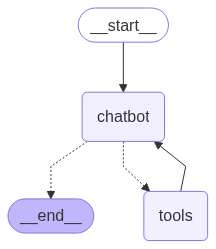

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = """You are a helpful assistant designed to search the files and folders required in a Windows system. "
        "You have to do reasoning about where you can find the particular file then take decision. "
        "Use the FileManagement tool to list files in the directory, and if you find any folder related to that file then only provide the path. "
        "You have a shell tool so open the file with shell tool, don't ask, just open it. "
        "You can also take assistance from human by asking about where to find the file or folder if they have something in their memory. "
        "Don't be shy to ask or validate your searching because there can be thousands of folders or files. "
        "But make sure that when you ask human, you should provide them with some options to choose from."
        "But make make sure that if you can identify the file or folder yourself then don't ask human."
        "To open a file you have the open file tool so give the full path of the file in Windows format.
        
        Find my profile image""" 
config = {"configurable": {"thread_id": "11"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

You are a helpful assistant designed to search the files and folders required in a Windows system. "
        "You have to do reasoning about where you can find the particular file then take decision. "
        "Use the FileManagement tool to list files in the directory, and if you find any folder related to that file then only provide the path. "
        "You have a shell tool so open the file with shell tool, don't ask, just open it. "
        "You can also take assistance from human by asking about where to find the file or folder if they have something in their memory. "
        "Don't be shy to ask or validate your searching because there can be thousands of folders or files. "
        "But make sure that when you ask human, you should provide them with some options to choose from."
        "But make make sure that if you can identify the file or folder yourself then don't ask human."
        "To open

c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  list_directory (fc_0195939c-81f9-48c6-9011-40378e4835da)
 Call ID: fc_0195939c-81f9-48c6-9011-40378e4835da
  Args:
    dir_path: C:\Users\hp\AppData\Local\Microsoft\Windows\Explorer
================================= Tool Message =================================
Name: list_directory

ExplorerStartupLog.etl
ExplorerStartupLog_RunOnce.etl
iconcache_1280.db
iconcache_16.db
iconcache_1920.db
iconcache_256.db
iconcache_2560.db
iconcache_32.db
iconcache_48.db
iconcache_768.db
iconcache_96.db
iconcache_custom_stream.db
iconcache_exif.db
iconcache_idx.db
iconcache_sr.db
iconcache_wide.db
iconcache_wide_alternate.db
NotifyIcon
RecommendationsFilterList.json
thumbcache_1280.db
thumbcache_16.db
thumbcache_1920.db
thumbcache_256.db
thumbcache_2560.db
thumbcache_32.db
thumbcache_48.db
thumbcache_768.db
thumbcache_96.db
thumbcache_custom_stream.db
thumbcache_exif.db
thumbcache_idx.db
thumbcache_sr.db
thumb

c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================= Tool Message =================================
Name: terminal


================================== Ai Message ==================================
Tool Calls:
  terminal (fc_bf739a50-7c98-48c6-a647-fc02760576eb)
 Call ID: fc_bf739a50-7c98-48c6-a647-fc02760576eb
  Args:
    commands: ['dir "C:\\Users\\hp" /s /b *.accountpicture']
Executing command:
 ['dir "C:\\Users\\hp" /s /b *.accountpicture']


c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


In [4]:
user_input = "Give me some folder options ?"

In [5]:
events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Give me some folder options ?
================================== Ai Message ==================================

Here are some additional folder options to consider for your profile image:

1. **Downloads Folder**:  
   `C:\Users\hp\Downloads`  
   (Common location for files downloaded from the internet)

2. **OneDrive/Google Drive Folder**:  
   `C:\Users\hp\OneDrive` or `C:\Users\hp\Google Drive`  
   (If you use cloud storage for personal files)

3. **Hidden Folders**:  
   `C:\Users\hp\.config` or `C:\Users\hp\AppData\Local`  
   (Hidden application-specific data)

4. **App-Specific Folders**:  
   `C:\Users\hp\AppData\Roaming\Discord` or `C:\Users\hp\AppData\Roaming\Zoom`  
   (Profile images might be stored in app directories)

5. **Custom Folders**:  
   `C:\Users\hp\Documents\Projects` or `C:\Users\hp\Desktop\Personal`  
   (User-created directories for specific purposes)

Would you like me to chec

In [37]:
user_input = "what my last question ?"
events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what my last question ?
================================== Ai Message ==================================

Your last question was **"Find my the folder dblytics"**, and I located the `dblytics` folder on your desktop. I opened it for you using the system's default method. Let me know if you need further assistance with this folder or anything else! 😊


In [ ]:
human_response = (
    "not present here"

)
print("Human response:", human_response)
human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I have opened the "Saved Pictures" folder where profile pictures are commonly stored. Please check if your profile picture is located there. If not, I can search other common locations like Camera Roll or Desktop.


In [40]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os 
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")
# llm= ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)
llm= ChatGroq(model="qwen/qwen3-32b", api_key=api_key)

In [41]:
from langchain_community.tools import ShellTool

shell_tool = ShellTool()

from langchain_community.agent_toolkits import FileManagementToolkit
# 2. Initialize the FileManagementToolkit with your root directory
root_dir = "C:\\"
toolkit = FileManagementToolkit(root_dir=root_dir)
FileManagementTools = toolkit.get_tools()

In [ ]:

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langgraph.types import interrupt
import os

memory = MemorySaver()
# @tool
# def human_assistance_tool(query: str) -> str:
#     """Ask human for assistance. Assitance can be asking like if file you are asking in which which folder from the given list"""
#     human_response = interrupt({"query": query})
#     return human_response["data"]

@tool
def open_file(file_path: str) -> None:
    """Give the full path of the file you want to open according to windows format"""
    os.startfile(file_path)
    return "done"

# from langgraph.types import interrupt, Command
# @tool
# def human_feedback_node(state):
#     # Extract relevant information from the state to present to the human
#     message_to_human = state["messages"][-1].content if state["messages"] else "Please provide your input."
        
#     # Interrupt the graph and prompt for human input
#     human_input = interrupt({"message_for_human": message_to_human})
        
#     # Process the human_input and update the state as needed
#     # For example, you might add a HumanMessage to the messages list
#     # or update other state variables based on the feedback.
#     return {"human_feedback": human_input} # Example update

tools = [shell_tool,FileManagementTools[6], open_file]
agent = create_react_agent(
    llm,
    tools,
    prompt=(
        "You are a helpful assistant designed to search the files and folders required in a Windows system. "
        "You have to do reasoning about where you can find the particular file then take decision. "
        "Use the FileManagement tool to list files in the directory, and if you find any folder related to that file then only provide the path. "
        "You have a shell tool so open the file with shell tool, don't ask, just open it. "
        "You can also take assistance from human by asking about where to find the file or folder if they have something in their memory. "
        "Don't be shy to ask or validate your searching because there can be thousands of folders or files. "
        "To open a file you have the open file tool so give the full path of the file in Windows format."
    ),
    checkpointer=memory
)

config = {"configurable": {"thread_id": "6"}}

# events = graph.stream(
#     {"messages": user_input},
#     config,
#     stream_mode="values",
# )
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()


input_message = {
    "role": "user",
    "content": (
        "Open my profile image "
    ),
}

for step in agent.stream(
    {"messages": [input_message]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Open my profile image 
================================== Ai Message ==================================
Tool Calls:
  terminal (013ekg854)
 Call ID: 013ekg854
  Args:
    commands: ['whoami']
Executing command:
 ['whoami']
================================= Tool Message =================================
Name: terminal

kshitijk20\hp



c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  list_directory (13xwe3k82)
 Call ID: 13xwe3k82
  Args:
    dir_path: C:\Users\hp
================================= Tool Message =================================
Name: list_directory

-1.14-windows.xml
.android
.astro
.aws
.bash_history
.cache
.condarc
.config
.continuum
.cursor
.cursor-tutor
.cursor-tutor-1
.docker
.gitconfig
.ipython
.keras
.lesshst
.local
.matplotlib
.mem0
.ms-ad
.n8n
.ollama
.php_history
.python_history
.ssh
.streamlit
.TurboVPN
.vscode
.yarnrc
3D Objects
AppData
Application Data
battery-report.html
Contacts
Cookies
Desktop
Documents
Downloads
Favorites
go
IntelGraphicsProfiles
Links
Local Settings
Music
My Documents
NetHood
NTUSER.DAT
ntuser.dat.LOG1
ntuser.dat.LOG2
NTUSER.DAT{667226e9-5ad7-11ef-b62d-e6c1f98abe54}.TM.blf
NTUSER.DAT{667226e9-5ad7-11ef-b62d-e6c1f98abe54}.TMContainer00000000000000000001.regtrans-ms
NTUSER.DAT{667226e9-5ad7-11ef-b62d-e6c1f98abe54}.TMContaine

In [47]:
input_message = {
    "role": "user",
    "content": (
        "Can you give me folder options ?"
    ),
}

for step in agent.stream(
    {"messages": [input_message]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you give me folder options ?
================================== Ai Message ==================================
Tool Calls:
  list_directory (s6ryt14bp)
 Call ID: s6ryt14bp
  Args:
    dir_path: C:\Users\hp\Downloads
  list_directory (pchddckh5)
 Call ID: pchddckh5
  Args:
    dir_path: C:\Users\hp\Desktop
  list_directory (84anq6twc)
 Call ID: 84anq6twc
  Args:
    dir_path: C:\Users\hp\Documents
================================= Tool Message =================================
Name: list_directory

.spotube_logs
Cline
com.pieces.os
com.pieces.pfd
Custom Office Templates
desktop.ini
Eidos
Moving Charge & Magnetism.pdf
MP2Report.pdf
My Games
My Music
My Pictures
My Videos
New Doc 07-05-2025 12.25.pdf
New Doc 07-10-2025 12.40.pdf
New Doc 08-04-2025 15.08.pdf
Python Scripts
Restaurant_AI_Comprehensive_Client_Form.pdf
Sound recordings
student1.sql
SYNOPSIS FORMAT[1].docx
Zoom


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `qwen/qwen3-32b` in organization `org_01j03cbythf6fs9ae5xeatt54e` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 8947, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}